In [1]:
#Adrian del Pozo Hernandez
#Ines Primo Lopez

import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as sg 
from tkinter import *
#import kbhit
# gráficos en el notebook
%matplotlib inline
SRATE = 44100 # Sample rate, para todo el programa
CHUNK = 1024

In [2]:
class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0,shape='sin'):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0
        self.shape = shape

    def next(self):    
        if self.shape=='sin':
            out = np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='square':
            out = sg.square(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='sawtooth':
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='triangle':
            # Ojo, la triangular no existe como tal en scipy, pero podemos hacerla con dos sawtooth
            # el 2º parametro define la "rampa" la subida y bajada (ver documentacion)
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase,0.5)
        self.frame += CHUNK

        return np.float32(self.amp*out)

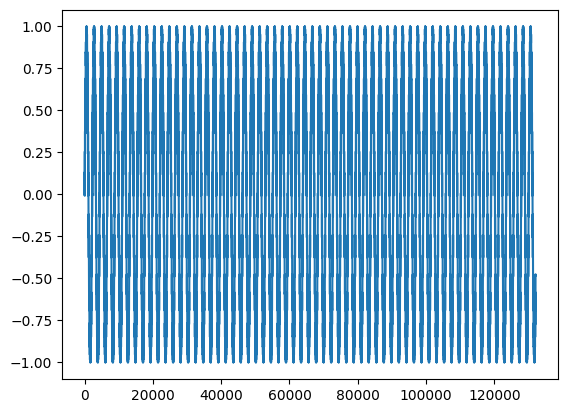

In [3]:
class OscFM:
    def __init__(self,fc=110.0,amp=1.0,fm=6.0, beta=1.0):
        self.fc = fc
        self.amp = amp
        self.fm = fm
        self.beta = beta
        self.frame = 0

        #Preguntar porque llama a esto moduladora
        #moduladora = βsin(2πfm)
        self.mod = Osc(freq=self.fm,amp=self.beta)
        
    def next(self):  
        # sin(2πfc+mod)  
        # sacamos el siguiente chunk de la moduladora
        mod = self.mod.next()

        # soporte para el chunk de salida
        sample = np.arange(self.frame,self.frame+CHUNK)        
        # aplicamos formula
        out =  self.amp*np.sin(2*np.pi*self.fc*sample/SRATE + mod)
        self.frame += CHUNK
        return out 
    
    def getFM(self):
        return self.fm
    
    def getBeta(self):
        return self.beta
    
    def setFM(self, fm):
        self.fm = fm
        self.mod.freq = fm

    def setBeta(self, beta):
        self.beta = beta
        self.mod.amp = beta
    

signal = OscFM(fc=20,fm=1000,beta=0.1)

# generamos 1.5 segundos de señal modulada
time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

varios = np.zeros(0)
for i in range(chunks):
    varios = np.append(varios,signal.next())

sd.play(varios)

plt.plot(varios)

sd.wait()

In [4]:
def callback(outdata, frames, time, status):
    s = signal.next()
    outdata[:] = s.reshape(-1, 1)

# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

# inicialización de la ventanas 
root=Tk()

# Caja de texto
text = Text(root,height=6,width=60)
text.pack(side=BOTTOM)
text.insert(INSERT,"Press 'm/M' to increase and decrease modular frequency and 'b/B' to increase and decrease beta\n")

# call back para la pulsación de teclas
def key_down(event):

    global signal
    if event.char=='m': 
        signal.setFM(signal.getFM() + 200)
    elif event.char == 'M':
        signal.setFM(signal.getFM() - 200)
    elif event.char=='b': 
        if signal.getBeta() < 1:
            signal.setBeta(signal.getBeta() + 0.1)
    elif event.char == 'B':
        if signal.getBeta() > 0:
            signal.setBeta(signal.getBeta() - 0.1)
        else:
            signal.setBeta(0)



# enlace de la pulsación de teclas con la función key_down
text.bind('<Key>', key_down)


# arrancamos todo!!
root.mainloop()
# ejecución bloqueada hasta que se cierre ventana

# limpieza..
stream.stop()
stream.close()